In [1]:
"""
A single objective evolutionary algortihm which evolves quantum circuits
according to a goal circuit using Qiskit
"""
import random
import math
import numpy as np
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt
from deap import base, creator, tools
from qiskit import QuantumCircuit
from qft_circuits import *
from grover_circuits import *

def random_gate():
    """ 
    Selects and returns a random gate from the gate set of the
    specified gate.

    Returns:
        [int, [int, int]]: Returns a random gate from the gate set of the
            specified circuit. This enables the initial population to be
            created and has a format which matches the built in qiskit
            representation.
    """
    return random.choice(qpossible_gates_1)

def circuit_fitness(current_circuit, gate_set, target_matrix, num_qubits):
    """
    Converts the provided circuit into a Quantum Circuit object that Qiskit can
    operate on and then calculates the fitness of the circuit (the element to element
    difference between it's matrix and the target circuit's matrix).

    Args:
        current_circuit ([int, [[int, [int, int]]]): This typecasting is not absolute
            as some gates only affect one qubit or represent a wire. The current circuit
            being evaluated by the algorithm, stored in a format that can easily be
            converted into a Qiskit represntation.
        gate_set ([int, [[int, [int, int]]]): This typecasting is not aboslute for the
            same aforementioned reasons. This is the complete gate set for the current
            algorithm and number of qubits, again stored in a format that enables them
            to be added and removed from circuits with ease.
        target_matrix ([[float]]): The array of imaginary float values representing the
            goal circuit, which enables the difference between elements in the matrix
            to be calculated.
        num_qubits (int): The number of qubits being used by the circuit, stored
            as an integer as this value is a whole number.

    Returns:
        (fitness,): The Deap library requires all evaluation functions to return
            a tuple (single objective is treated as a special case of multi-objective).
            The float representing the difference between the current circuit and the
            goal is returned in the desired format.
    """
    # Converts the representation of the current circuit into a QuantumCircuit object
    qiskit_representation = convert_circuit(current_circuit, num_qubits, gate_set)
    # Finds the matrix representing the current quantum circuit
    circuit_unitary_matrix = qi.Operator(qiskit_representation)
    circuit_unitary_matrix = circuit_unitary_matrix.data
    # The circuit's fitness is the sum of the absolute element to element difference
    fitness = 0
    for i in range(0, len(circuit_unitary_matrix)):
        for j in range(0, len(circuit_unitary_matrix[i])):
            fitness += abs(circuit_unitary_matrix[i][j] - target_matrix[i][j])

    return (fitness,)

def circuit_size(current_circuit):
    """
    Calculates and returns the number of gates within a quantum circuit,
    using my proprietary (non-qiskit) representation.

    Args:
        current_circuit ([int, [[int, [int, int]]]): This typecasting is not absolute
            as some gates only affect one qubit or represent a wire. The current circuit
            being evaluated by the algorithm, stored in a format that can easily be
            converted into a Qiskit represntation.
    
    Returns:
        size (int): The size of the circuit, as an integer as this value is a whole
            number.
    """
    size = 0
    # Loops through each index in the circuit representation
    # The size counter is incremented for each index that isn't a wire
    for gate in current_circuit:
        if gate[0] != 10:
            size += 1

    return size

def convert_circuit(current_circuit, num_qubits, gate_set):
    """
    Converts a list based representation of a quantum circuit into a Qiskit compatible
    QuantumCircuit object which can be modified and read with Qiskit's methods.

    Args:
        current_circuit ([int, [[int, [int, int]]]): This typecasting is not absolute
            as some gates only affect one qubit or represent a wire. The current circuit
            being evaluated by the algorithm, stored in a format that can easily be
            converted into a Qiskit represntation.
        num_qubits (int): The number of qubits being used by the circuit, stored
            as an integer as this value is a whole number.
        gate_set ([int, [[int, [int, int]]]): This typecasting is not aboslute for the
            same aforementioned reasons. This is the complete gate set for the current
            algorithm and number of qubits, again stored in a format that enables them
            to be added and removed from circuits with ease.

    Returns:
        circuit (QuantumCircuit(int)): The Qiskit QuantumCircuit representation of the
            circuit being evaluated by the algorithm.
    """
    # Creates a new QuantumCircuit object to add the gates to
    circuit = QuantumCircuit(num_qubits)
    for gate in current_circuit:
        # If the current gate is anything but a wire, decompose the gate and
        # add it to the QuantumCircuit object
        if gate_set[gate[0]] != 'WIRE':
            circuit.append(
                gate_set[gate[0]],
                gate[1]
            )

    return circuit

def mutate(circuit):
    """
    Mutates a random gate in the provided circuit by changing it to another gate
    from the gate set at random (this gate set is the one being used by the algorithm being
    evaluated at the given size). 

    Args:
        circuit ([int, [[int, [int, int]]]): This typecasting is not absolute
            as some gates only affect one qubit or represent a wire. The current circuit
            which is about to be mutated, stored in a format that can easily be
            converted into a Qiskit represntation.

    Returns:
        circuit ([int, [[int, [int, int]]]): This typecasting is not absolute
            as some gates only affect one qubit or represent a wire. The current circuit
            which has now been mutated by the algorithm (contains one gate which has
            potentially changed), stored in a format that can easily be converted into a
            Qiskit represntation.
    """
    # The current gate can be mutated to any other gate in the gate set
    possible_gates = qpossible_gates_1
    
    # Choose a random gate in the circuit via index to mutate
    mutation_index = random.randint(0, len(circuit) - 1)
    # Choose a random gate from the gate set to replace said gate
    circuit[mutation_index] = random.choice(possible_gates)

    # Deletes the mutated individuals fitness values as they are no
    # longer related to the individual
    del circuit.fitness.values

    return circuit    

def crossover(circuit1, circuit2):
    """
    Executes a two point crossover between two provided circuits by selecting
    two indexes (gates) at random and swapping all the indexes (gates)
    between them.

    Args:
        circuit1 ([[int, [int, int]]]): This typecasting is not absolute
            as some gates only affect one qubit or represent a wire. The first circuit
            to be crossed over with the circuit below, stored in a format that can
            easily be converted into a Qiskit represntation.
        circuit2 ([[int, [int, int]]]): Akin to the other circuit this typecasting is not
            absolute. The second parent circuit to be crossed over with the above circuit.
            stored in a format that can easily be converted into a Qiskit represntation.

    Returns:
        ([[int, [int, int]]], [[int, [int, int]]])
    """
    # Specifies that two point crossover is to be used
    # (more points can be used)
    num_points = 2
    # Chooses num_points random indicies to swap
    # If there is an odd number of points selected, the end of the list is
    # chosen as the end point for the second crossover
    if num_points%2 != 0:
        indicies = []
        indicies.append(len(circuit1) - 1)
    else:
        indicies = []
    
    # Validates that no two crossover points are the same
    for i in range(0, num_points):
        temp_index = random.randint(0, len(circuit1) - 1)
        while temp_index in indicies:
            temp_index = random.randint(0, len(circuit1) - 1)

        indicies.append(temp_index)

    # Sorts the list of indexes so that the crossover can be performed correctly
    indicies.sort()

    # Performs the crossover in place, swapping all values between the crossover points
    for i in range(0, len(indicies), 2):
        temp_values = circuit1[indicies[i]:indicies[i+1]]
        circuit1[indicies[i]: indicies[i+1]] = circuit2[indicies[i]: indicies[i+1]]
        circuit2[indicies[i]: indicies[i+1]] = temp_values

    # Deletes the fitness values associated with the "mated" circuits
    # As they are no longer related to the individual
    del circuit1.fitness.values
    del circuit2.fitness.values

    return (circuit1, circuit2)  

CIRCUIT_TYPE = "qft"
# QFT circuits only need to decomposed once, whereas Grover's algorithm circuits need to be decomposed twice
if CIRCUIT_TYPE == "qft":
    # The two qubit QFT circuit is being created in this instance
    goal_circuit = qft_circuit1
    gate_set = qgate_set1
    # Stores the pdf diagram of the goal circuit into the stated file
    goal_circuit.decompose().draw(output="latex", filename="test_circuit.pdf")
    # When calculating the goal matrix, the circuit isn't decomposed as this seems to have some impact
    # on the values stored in the unitary matrix
    goal_matrix = qi.Operator(goal_circuit)
    # Stores the goal matrix and the goal circuit
    goal_matrix = goal_matrix.data
    goal_circuit = qft_circuit1.decompose()
elif CIRCUIT_TYPE == "grover":
    # The three qubit Grover circuit is being created in this instance
    goal_circuit = grover_circuit3
    gate_set = ggate_set3
    # Stores the pdf diagram of the goal circuit into the stated file
    goal_circuit.decompose().decompose().draw(output="latex", filename="test_circuit.pdf")
    goal_matrix = qi.Operator(goal_circuit)
    # Stores the goal matrix and goal circuit
    goal_matrix = goal_matrix.data
    goal_circuit = grover_circuit3.decompose().decompose()

# Creates a minimising fitness object via DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
# Creates an object for each inidivdual in the population (an empty list)
# with a fitness value linked to the minimising object above
creator.create("Individual", list, fitness=creator.FitnessMin)

# Circuit length is 1 + the size of the circuit to promote circuit diversity
CIRCUIT_LENGTH = circuit_size(goal_circuit) + 1

# Creates the DEAP toolbox object
toolbox = base.Toolbox()
# The genes in the genome are randomly assigned gates from the gate set
toolbox.register("attribute_gate", random_gate,)
# Uses the DEAP toolbox to repeatedly create a population of individuals with the
# desired length and random values
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attribute_gate, n=CIRCUIT_LENGTH)
# Registers a bag population (one without ordering) via the DEAP toolbox
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Uses the DEAP toolbox to register tools for each of the operators
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate)
# toolbox.register("select", tournament_selection)
toolbox.register("select", tools.selTournament)
toolbox.register("evaluate", circuit_fitness, gate_set=gate_set, target_matrix=goal_matrix, num_qubits=2)
# Registers the statistics objects to track the overall fitness and size circuits over the whole evolution
statistics_fitness = tools.Statistics(key=lambda ind: ind.fitness.values[0])
statistics_size = tools.Statistics(key=circuit_size)
m_statistics = tools.MultiStatistics(fitness=statistics_fitness, size=statistics_size)
m_statistics.register("average", np.mean)
m_statistics.register("minimum", np.min)
m_statistics.register("maximum", np.max)
# Creates the logbook to store all the statistical data
logbook = tools.Logbook()

[CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 1),), clbits=()), CircuitInstruction(operation=Instruction(name='cp', num_qubits=2, num_clbits=0, params=[1.5707963267948966]), qubits=(Qubit(QuantumRegister(2, 'q'), 1), Qubit(QuantumRegister(2, 'q'), 0)), clbits=()), CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='swap', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)), clbits=())]
16
26
70


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit/visualization/circuit/latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)


In [2]:
def main():
    """
    Sets the parameters for and executes the entire genetic algorithm.

    Returns:
        logbook (tools.Logbook()): The DEAP logbook object storing the size
            and fitness statistics stored by the algorithm throughout the
            entire evolution.
    """
    # Declares the parameters to be used by the genetic algorithm
    NUM_GENERATIONS = 400
    POP_SIZE = 600
    MUTATION_RATE = 0.8
    CROSSOVER_RATE = 0.6
    ELITISM_RATE = math.floor(0.05 * POP_SIZE)
    # Creates an initial population of size POP_SIZE
    population = toolbox.population(n=POP_SIZE)

    # Stores the genetic representation and fitness values of the best solution found thus far
    # Initialised with placeholder values
    best_solution = [math.inf, 0]

    # Evalutes each circuit in the population so that they all have a fitness value
    for circuit in population:
        circuit.fitness.values = circuit_fitness(circuit, gate_set, goal_matrix, 2)

    # Executes the genetic algorithm until the number of generations is reached
    for gen in range(0, NUM_GENERATIONS):
        # Selects the individuals to be used in the current generation
        offspring = toolbox.select(population, len(population), 4)
        # Clones the selected population so that it can be altered
        offspring = list(map(toolbox.clone, offspring))

        next_gen_population = []
        # Sorts the offspring so that the fittest circuits can be found
        for i in range(0, len(population)):
            fitness, = circuit_fitness(population[i], gate_set, goal_matrix, 2)
            next_gen_population.append((fitness, population[i]))

        # Sorts the population according to fitness values
        next_gen_population.sort()
        # Replaces the current solution with the current solution if it is fitter
        if next_gen_population[0][0] < best_solution[0]:
            best_solution[0] = next_gen_population[0][0]
            best_solution[1] = next_gen_population[0][1]

        temp_list = []
        # Adds the ELITISM_RATE best solutions from the population to the temp list
        for i in range(0, ELITISM_RATE):
            temp_list.append(next_gen_population[i][1])
        
        # Resets the population for the next generation so that only the ELITISM_RATE best
        # circuits are copied over
        next_gen_population = temp_list

        # Applies crossover to this generation of circuits
        for c1, c2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CROSSOVER_RATE:
                toolbox.mate(c1, c2)
                # Deletes the fitness values from the parent circuits as they have been
                # altered (value no longer corresponds to the circuit's actual fitness)
                del c1.fitness.values
                del c2.fitness.values
        
        # Applies mutation to this generation of circuits
        for child in offspring:
            if random.random() < MUTATION_RATE:
                toolbox.mutate(child)
                # For the aforementioned reason, deletes the circuits fitness value
                del child.fitness.values

        # Re-evaluates the fitness of all individuals that have been altered via
        # crossover and/or mutation
        altered_circuits = []
        for child in offspring:
            if not child.fitness.valid:
                altered_circuits.append(child)
        
        # Maps the fitness values back to these altered circuits
        fitnesses = toolbox.map(toolbox.evaluate, altered_circuits)
        for (circuit, fitness) in zip(altered_circuits, fitnesses):
            circuit.fitness.values = fitness

        # Randomly pick circuits from the offspring to fill the rest of
        # the next generation's population
        while len(next_gen_population) < len(population):
            chosen_circuit = random.choice(offspring)
            next_gen_population.append(chosen_circuit)
            # Removes the circuit, so there is less chance duplicate individuals
            # end up in the next generation
            offspring.remove(chosen_circuit)    

        # Updates the population
        population[:] = next_gen_population
        record = m_statistics.compile(population)
        logbook.record(**record)
    
    # Outputs the circuit representation of the best circuit found
    best_circuit = convert_circuit(best_solution[1], 2, gate_set)
    # Displays statistics from the run of the EA
    print("the size of the best circuit is:", circuit_size(best_solution[1]))
    print("The best circuit had a fitness of", best_solution[0], "and is represented by:")
    print(best_circuit)
    # Displays the unitary matrix representing the best solution
    best_circuit_matrix = qi.Operator(best_circuit)
    print(best_circuit_matrix.data)
    best_circuit.draw(output="latex", filename="best_circuit.pdf")
    # Returns all the statistics so they can be plot in a matplotlib diagram
    return logbook

In [3]:
def genetic_algorithm_results_plotter(logbook):
    """
    Using the contents of the logbook, graphs are compiled and displayed to diagramatically
    display the performance of the algorithm over the course of the given evolution.

    Args:
        (tools.Logbook()): The DEAP logbook object storing the size and
            fitness statistics stored by the algorithm throughout the
            entire evolution.
    """
    # Specifies the parameters and data to be extrapolated from the logbook
    NUM_GENERATIONS = 400
    logbook.header = "fitness", "size"
    logbook.chapters["fitness"].header = "average"
    logbook.chapters["size"].header = "average"

    # Sets the x-axis value to the first 100 natural numbers
    xaxis = [i for i in range(1,NUM_GENERATIONS + 1)]
    # Sets the y-axis to the average fitness values across the evolution
    yaxis1 = logbook.chapters["fitness"].select("average")
    plt.plot(xaxis, yaxis1)

    # The titles for the first graph
    plt.title("Average Circuit Fitness Over the Evolution")
    plt.xlabel("Generation")
    plt.ylabel("Average Circuit Fitness")

    plt.show()

    # The second graph maps the fitness values over the evolution
    yaxis2 = logbook.chapters["fitness"].select("minimum")
    plt.plot(xaxis, yaxis2)

    # The titles for the second graph
    plt.title("Minimum Circuit Fitness Over the Evolution")
    plt.xlabel("Generation")
    plt.ylabel("Minimum Circuit Fitness")

    plt.show()
    
    # The third graph maps the average size of circuits over the evolution
    # The average size values across the evolution
    yaxis3 = logbook.chapters["size"].select("average")
    plt.plot(xaxis, yaxis3)

    # The titles for the third graph
    plt.title("Average Circuit Size Over the Evolution")
    plt.xlabel("Generation")
    plt.ylabel("Average Circuit Size")

    plt.show()

the size of the best circuit is: 4
The best circuit had a fitness of 0.0 and is represented by:
                           
q_0: ──────X──■────────────
     ┌───┐ │  │P(π/2) ┌───┐
q_1: ┤ H ├─X──■───────┤ H ├
     └───┘            └───┘
[[ 5.000000e-01+0.j   5.000000e-01+0.j   5.000000e-01+0.j
   5.000000e-01+0.j ]
 [ 5.000000e-01+0.j   3.061617e-17+0.5j -5.000000e-01+0.j
  -3.061617e-17-0.5j]
 [ 5.000000e-01+0.j  -5.000000e-01+0.j   5.000000e-01+0.j
  -5.000000e-01+0.j ]
 [ 5.000000e-01+0.j  -3.061617e-17-0.5j -5.000000e-01+0.j
   3.061617e-17+0.5j]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit/visualization/circuit/latex.py:154: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, _ = load_style(style)


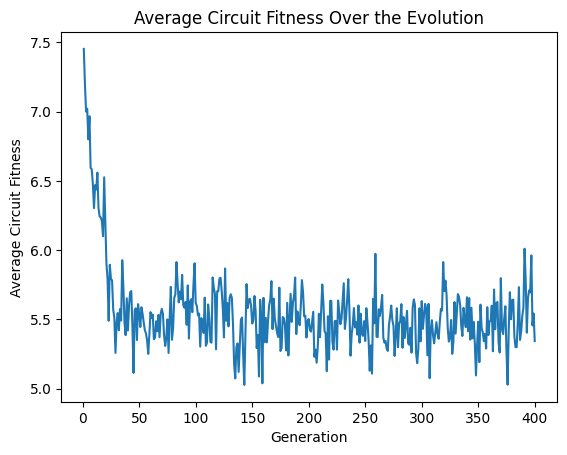

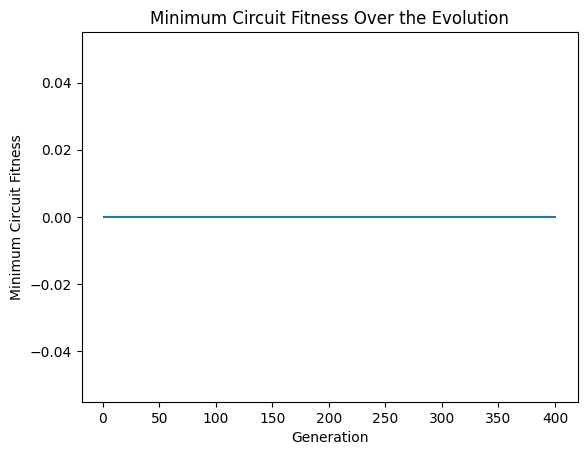

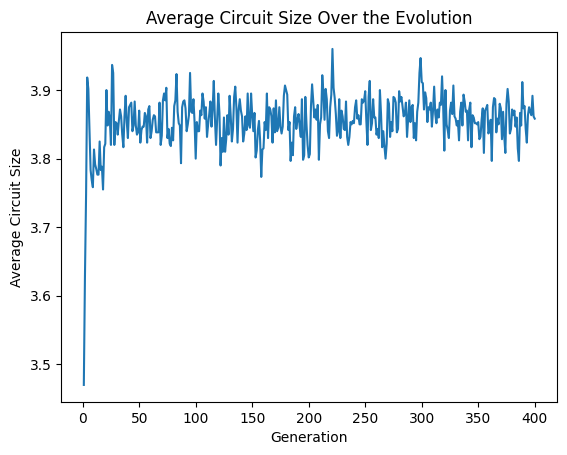

In [4]:
if __name__ == "__main__":
    # Executes the genetic algorithm and collects the best circuit's fitness and size
    data = main()
    # Create and display graphs on the algorithm's performance over the evolution
    genetic_algorithm_results_plotter(data)